## Get all APOGEE XP coeffs

In [ ]:
import h5py
import numpy as np

from astropy.io import fits
from astroNN.apogee import allstar
from mygaiadb.spec import yield_xp_coeffs


allstar_f = fits.getdata(allstar(dr=17))
all_coeffs = np.zeros((len(allstar_f), 110), dtype=np.float64)
all_coeffs_err = np.zeros((len(allstar_f), 110), dtype=np.float64)
all_bp_n_relevant_bases = np.zeros(len(allstar_f), dtype=np.int8)
all_rp_n_relevant_bases = np.zeros(len(allstar_f), dtype=np.int8)

for i in yield_xp_coeffs(allstar_f["GAIAEDR3_SOURCE_ID"], assume_unique=False, return_errors=True, return_additional_columns=["bp_n_relevant_bases", "rp_n_relevant_bases"]):
    coeffs, idx, coeffs_err, bp_n_relevant_bases, rp_n_relevant_bases = i
    all_coeffs[idx] = coeffs
    all_coeffs_err[idx] = coeffs_err
    all_bp_n_relevant_bases[idx] = bp_n_relevant_bases
    all_rp_n_relevant_bases[idx] = rp_n_relevant_bases

print(
    "Number of APOGEE stars without Gaia DR3 Source ID: ",
    np.sum(allstar_f["GAIAEDR3_SOURCE_ID"] == 0),
)
print("Number of APOGEE stars with Gaia XP spectra: ", np.sum(np.sum(all_coeffs, axis=1) != 0))

all_coeffs = np.where(all_coeffs==0, np.nan, all_coeffs)

xp_relevancy = np.zeros_like(all_coeffs, dtype=bool)  # boolean array to indicate which coefficients are relevant
for idx, (x, y) in enumerate(zip(all_bp_n_relevant_bases, all_rp_n_relevant_bases)):
    if x > 0:
        xp_relevancy[idx, :x] = True
        xp_relevancy[idx, 55:55+y] = True

# Gaia XP coeffs row-matched to APOGEE DR17
f = h5py.File("./data_files/apogee_xp_coeffs_only.h5", "w")
f.create_dataset("xp_coeffs", data=all_coeffs)
f.create_dataset("xp_coeffs_err", data=all_coeffs_err)
f.create_dataset("xp_relevancy", data=xp_relevancy)
f.create_dataset("bp_n_relevant_bases", data=all_bp_n_relevant_bases)
f.create_dataset("rp_n_relevant_bases", data=all_rp_n_relevant_bases)
f.close()

## Get Missing Columns from Gaia

In [ ]:
from astropy.io import fits
from astropy.table import Table
from astroquery.gaia import Gaia
from astroNN.apogee import allstar

allstar_f = fits.getdata(allstar(dr=17))


# launching job at https://gea.esac.esa.int/archive/
job = Gaia.launch_job_async(
    f"""
    select g.*
    from gaiadr3.gaia_source as g 
    inner join tap_upload.my_table as m on m.source_id = g.source_id
    """,
    upload_resource=Table({"source_id": allstar_f["GAIAEDR3_SOURCE_ID"]}),
    upload_table_name="my_table",
)

# parse job result and save
gaia_matches = job.results
gaia_matches["DESIGNATION"] = gaia_matches["DESIGNATION"].astype(str)
gaia_matches["phot_variable_flag"] = gaia_matches["phot_variable_flag"].astype(str)
gaia_matches["libname_gspphot"] = gaia_matches["libname_gspphot"].astype(str)

gaia_matches.write("./data_files/apogee_dr17_gaia_allcols.fits")

## Build Dataset for APOGEE stars

In [1]:
import h5py
import numpy as np

import mwdust
from zero_point import zpt
from mygaiadb.utils import radec_to_ecl

from astropy.io import fits
from astropy.stats import mad_std
from astroNN.apogee import allstar, bitmask_boolean
from astroNN.gaia import mag_to_fakemag
from sklearn.model_selection import train_test_split

from utils.gaia_utils import mag_to_flux, gaia_plx_zero_point

zpt.load_tables()

allstar_f = fits.getdata(allstar(dr=17))
apogee_xp_h5f = h5py.File("./data_files/apogee_xp_coeffs_only.h5", "r")
apogee_gaia_f = fits.getdata("./data_files/apogee_dr17_gaia_allcols.fits")
gaia_matched_idx = np.where(allstar_f["GAIAEDR3_SOURCE_ID"] > 1)[0]
ect_lon, ect_lat = radec_to_ecl(apogee_gaia_f["ra"], apogee_gaia_f["dec"])
gaia_g_apperent_flux = mag_to_flux(allstar_f["GAIAEDR3_PHOT_G_MEAN_MAG"])

xp_coeffs = apogee_xp_h5f["xp_coeffs"][()]
xp_coeffs_err = apogee_xp_h5f["xp_coeffs_err"][()]
xp_relevancy = apogee_xp_h5f["xp_relevancy"][()]
apogee_xp_h5f.close()

norm_xp_coeffs = xp_coeffs / np.expand_dims(gaia_g_apperent_flux, axis=-1)
norm_xp_coeffs_err = xp_coeffs_err / np.expand_dims(gaia_g_apperent_flux, axis=-1)

bp_rp = allstar_f["GAIAEDR3_PHOT_BP_MEAN_MAG"] - allstar_f["GAIAEDR3_PHOT_RP_MEAN_MAG"]
gaia_ruwe = np.ones(len(allstar_f)) * 99.0
phot_bp_rp_excess_factor = np.ones(len(allstar_f)) * 99.0
gaia_ruwe[gaia_matched_idx] = apogee_gaia_f["ruwe"]
phot_bp_rp_excess_factor[gaia_matched_idx] = apogee_gaia_f["phot_bp_rp_excess_factor"]

# ============================= Quality cuts with indices =============================
# Stars level cuts (i.e. cuts applied to all surveys because the stars themselves are bad according to any one of the surveys)
bad_idx = ()

# Gaia-centric cuts (Good Gaia data with or without APOGEE)
good_idx_gaia = (
    (np.sum(np.isnan(xp_coeffs), axis=1) == 0)
    # remove extreme fitted coeffs (for example caused by binary stars like 4095714078005133568)
    & np.all(norm_xp_coeffs > np.nanpercentile(norm_xp_coeffs, 0.2, axis=0), axis=1)
    & np.all(norm_xp_coeffs < np.nanpercentile(norm_xp_coeffs, 99.8, axis=0), axis=1)
    & (bp_rp > 0.0)
    & (bp_rp < 4.0)
    # see figure 23 in https://ui.adsabs.harvard.edu/abs/2022arXiv220606143D/abstract
    & (allstar_f["GAIAEDR3_PHOT_G_MEAN_MAG"] > 6.0)
    & (allstar_f["GAIAEDR3_PHOT_G_MEAN_MAG"] < 17.5)
    & (gaia_ruwe < 1.4)
    & (phot_bp_rp_excess_factor < 2.0)
    # try best to make sure the star is not a binary
    & ~bitmask_boolean(allstar_f["STARFLAG"], [2, 3])[0]
)
norm_xp_coeffs[~good_idx_gaia] = np.nan
norm_xp_coeffs_err[~good_idx_gaia] = np.nan

# APOGEE-centric cuts (good APOGEE data without Gaia)
good_idx_apogee = (
    (np.sum(np.isnan(xp_coeffs), axis=1) > 0)
    & (allstar_f["STARFLAG"] == 0)
    & (allstar_f["ASPCAPFLAG"] == 0)
)
# ============================= Quality cuts with indices =============================

gaia_parallax = allstar_f["GAIAEDR3_PARALLAX"]
gaia_parallax_zp = np.zeros(len(gaia_parallax))
good_zp_idx = (apogee_gaia_f["astrometric_params_solved"] == 31) | (
    apogee_gaia_f["astrometric_params_solved"] == 95
)

gaia_parallax_zp[gaia_matched_idx[good_zp_idx]] = gaia_plx_zero_point(
    apogee_gaia_f["phot_g_mean_mag"][good_zp_idx],
    apogee_gaia_f["nu_eff_used_in_astrometry"][good_zp_idx],
    apogee_gaia_f["pseudocolour"][good_zp_idx],
    ect_lat[good_zp_idx],
    apogee_gaia_f["astrometric_params_solved"][good_zp_idx],
    leung2023_correction=True,
)

gaia_parallax_zp_corrected = gaia_parallax - gaia_parallax_zp
gaia_parallax_err = allstar_f["GAIAEDR3_PARALLAX_ERROR"]
# assume gaia parallax is bad (by propagating NaN in zero-point) if any one of the conditions is met
gaia_parallax_zp_corrected[(gaia_parallax_err > 0.1) | (gaia_ruwe > 1.4)] = np.nan
# inverse parallax for extinction calculation, sample 100 times to propagate error
gaia_inverse_parallax_zp_corrected = (
    1
    / np.random.normal(
        gaia_parallax_zp_corrected, gaia_parallax_err, size=(1000, len(allstar_f))
    ).T
)
# if parallax is negative (with good astrometry) because it is small, assume star is far away for extinction calculation
gaia_inverse_parallax_zp_corrected[
    (gaia_parallax_err < 0.1) & (gaia_parallax <= 0) & (gaia_ruwe < 1.4), :
] = 99.0
# the remaining negative parallax stars are bad measurements so NaN for extinction calculation
gaia_inverse_parallax_zp_corrected[gaia_inverse_parallax_zp_corrected < 0] = np.nan

combined19 = mwdust.Combined19()
c19_samples = combined19(
    allstar_f["GLON"], allstar_f["GLAT"], gaia_inverse_parallax_zp_corrected
)
# c19_samples = np.random.normal(c19_samples, 0.05)  # assume a noise floor of 0.05
c19_samples[
    c19_samples > 10.0
] = np.nan  # if the extinction is too large, assume it's a bad measurement
c19_samples[c19_samples <= 0.0] = np.exp(-7.0)
logc19 = np.log(c19_samples)
logc19_err = mad_std(logc19, ignore_nan=True, axis=1)
logc19 = np.nanmedian(logc19, axis=1)

bp = allstar_f["GAIAEDR3_PHOT_BP_MEAN_MAG"]
rp = allstar_f["GAIAEDR3_PHOT_RP_MEAN_MAG"]
phot_bp_mean_flux_over_error = np.ones(len(bp)) * np.nan
phot_rp_mean_flux_over_error = np.ones(len(rp)) * np.nan
phot_bp_mean_flux_over_error[gaia_matched_idx] = apogee_gaia_f[
    "phot_bp_mean_flux_over_error"
]
phot_rp_mean_flux_over_error[gaia_matched_idx] = apogee_gaia_f[
    "phot_rp_mean_flux_over_error"
]
bp_error = np.sqrt(
    (-2.5 / np.log(10) * (1 / phot_bp_mean_flux_over_error)) ** 2 + 0.0027901700**2
)
rp_error = np.sqrt(
    (-2.5 / np.log(10) * (1 / phot_rp_mean_flux_over_error)) ** 2 + 0.0037793818**2
)
bp_rp = bp - rp
bp_rp_err = np.sqrt(bp_error**2 + rp_error**2)

jmag = np.where(allstar_f["J"] == 99.999, np.nan, allstar_f["J"])
hmag = np.where(allstar_f["H"] == 99.999, np.nan, allstar_f["H"])
kmag = np.where(allstar_f["K"] == 99.999, np.nan, allstar_f["K"])
jmag_err = allstar_f["J_ERR"]
hmag_err = allstar_f["H_ERR"]
kmag_err = allstar_f["K_ERR"]
jh = jmag - hmag
jh_err = np.sqrt(jmag_err**2 + hmag_err**2)
jk = jmag - kmag
jk_err = np.sqrt(jmag_err**2 + kmag_err**2)

g_fakemag, g_fakemag_err = mag_to_fakemag(
    allstar_f["GAIAEDR3_PHOT_G_MEAN_MAG"], gaia_parallax_zp_corrected, gaia_parallax_err
)

bad_aspcap_idx = bitmask_boolean(allstar_f["ASPCAPFLAG"], [19, 23])[0] | (
    allstar_f["STARFLAG"] != 0
)
teff = allstar_f["TEFF"]
logg = allstar_f["LOGG"]
mh = allstar_f["M_H"]
teff_err = allstar_f["TEFF_ERR"]
logg_err = allstar_f["LOGG_ERR"]
mh_err = allstar_f["M_H_ERR"]
teff[bad_aspcap_idx] = np.nan
logg[bad_aspcap_idx] = np.nan
mh[bad_aspcap_idx] = np.nan
teff_err[bad_aspcap_idx] = np.nan
logg_err[bad_aspcap_idx] = np.nan
mh_err[bad_aspcap_idx] = np.nan

# try to parse messy APOGEE_IDs
tmass_id = []
for i in allstar_f["APOGEE_ID"]:
    if len(i) == 18:
        tmass_id.append(i[2:].encode("ascii", "ignore"))
    elif len(i) == 17:
        tmass_id.append(i[1:].encode("ascii", "ignore"))
    elif len(i) == 16:
        tmass_id.append(i.encode("ascii", "ignore"))
    else:
        tmass_id.append("0".encode("ascii", "ignore"))
tmass_id = np.array(tmass_id)

idx_train, idx_testing = train_test_split(
    np.where(good_idx_gaia | good_idx_apogee)[0], test_size=0.1
)
print("Number of stars in training set:", len(idx_train))
print("Number of stars in testing set:", len(idx_testing))

for f_name, idx in zip(["training_set", "testing_set"], [idx_train, idx_testing]):
    f = h5py.File(f"./data_files/{f_name}.h5", "w")

    # designation
    f.create_dataset(
        "2mass_designation", (len(tmass_id[idx]), 1), "S16", data=tmass_id[idx]
    )  # simbad prefix = "2MASS J"
    f.create_dataset(
        "gaia_source_id", data=allstar_f["GAIAEDR3_SOURCE_ID"][idx]
    )  # simbad prefix = "Gaia DR3"

    raw = f.create_group("raw")

    # gaia
    raw.create_dataset("xp_coeffs", data=xp_coeffs[idx])
    raw.create_dataset("xp_coeffs_err", data=xp_coeffs_err[idx])
    raw.create_dataset("xp_coeffs_gnorm", data=norm_xp_coeffs[idx])
    raw.create_dataset("xp_coeffs_gnorm_err", data=norm_xp_coeffs_err[idx])
    raw.create_dataset("xp_relevancy", data=xp_relevancy[idx])

    raw.create_dataset("bprp", data=bp_rp[idx])
    raw.create_dataset("bprp_err", data=bp_rp_err[idx])
    raw.create_dataset("g_fakemag", data=g_fakemag[idx])
    raw.create_dataset("g_fakemag_err", data=g_fakemag_err[idx])
    raw.create_dataset("jh", data=jh[idx])
    raw.create_dataset("jk", data=jk[idx])
    raw.create_dataset("jh_err", data=jh_err[idx])
    raw.create_dataset("jk_err", data=jk_err[idx])
    # raw.create_dataset("logsfd", data=logsfd[idx])
    raw.create_dataset("logc19", data=logc19[idx])
    raw.create_dataset("logc19_err", data=logc19_err[idx])
    raw.create_dataset("parallax", data=gaia_parallax_zp_corrected[idx])
    raw.create_dataset("parallax_err", data=gaia_parallax_err[idx])
    raw.create_dataset(
        "phot_g_mean_mag", data=allstar_f["GAIAEDR3_PHOT_G_MEAN_MAG"][idx]
    )

    # apogee
    raw.create_dataset("teff", data=teff[idx])
    raw.create_dataset("logg", data=logg[idx])
    raw.create_dataset("m_h", data=mh[idx])
    raw.create_dataset("teff_err", data=teff_err[idx])
    raw.create_dataset("logg_err", data=logg_err[idx])
    raw.create_dataset("m_h_err", data=mh_err[idx])
    f.close()


Number of stars in training set: 410812
Number of stars in testing set: 45646


# Inspect Dataset

Total number of training star:  396718
Number of training star with Teff, logg, [M/H]:  260921
Number of training star with Teff:  263808
Number of training star with XP:  363261
Number of training star with XP without any APOGEE:  132910
Number of training star with APOGEE without XP:  33457
Number of training star without good Gaia parallax:  12065
Number of training star without Combined19 reddening:  11947
Number of training star without 2MASS colors:  2031


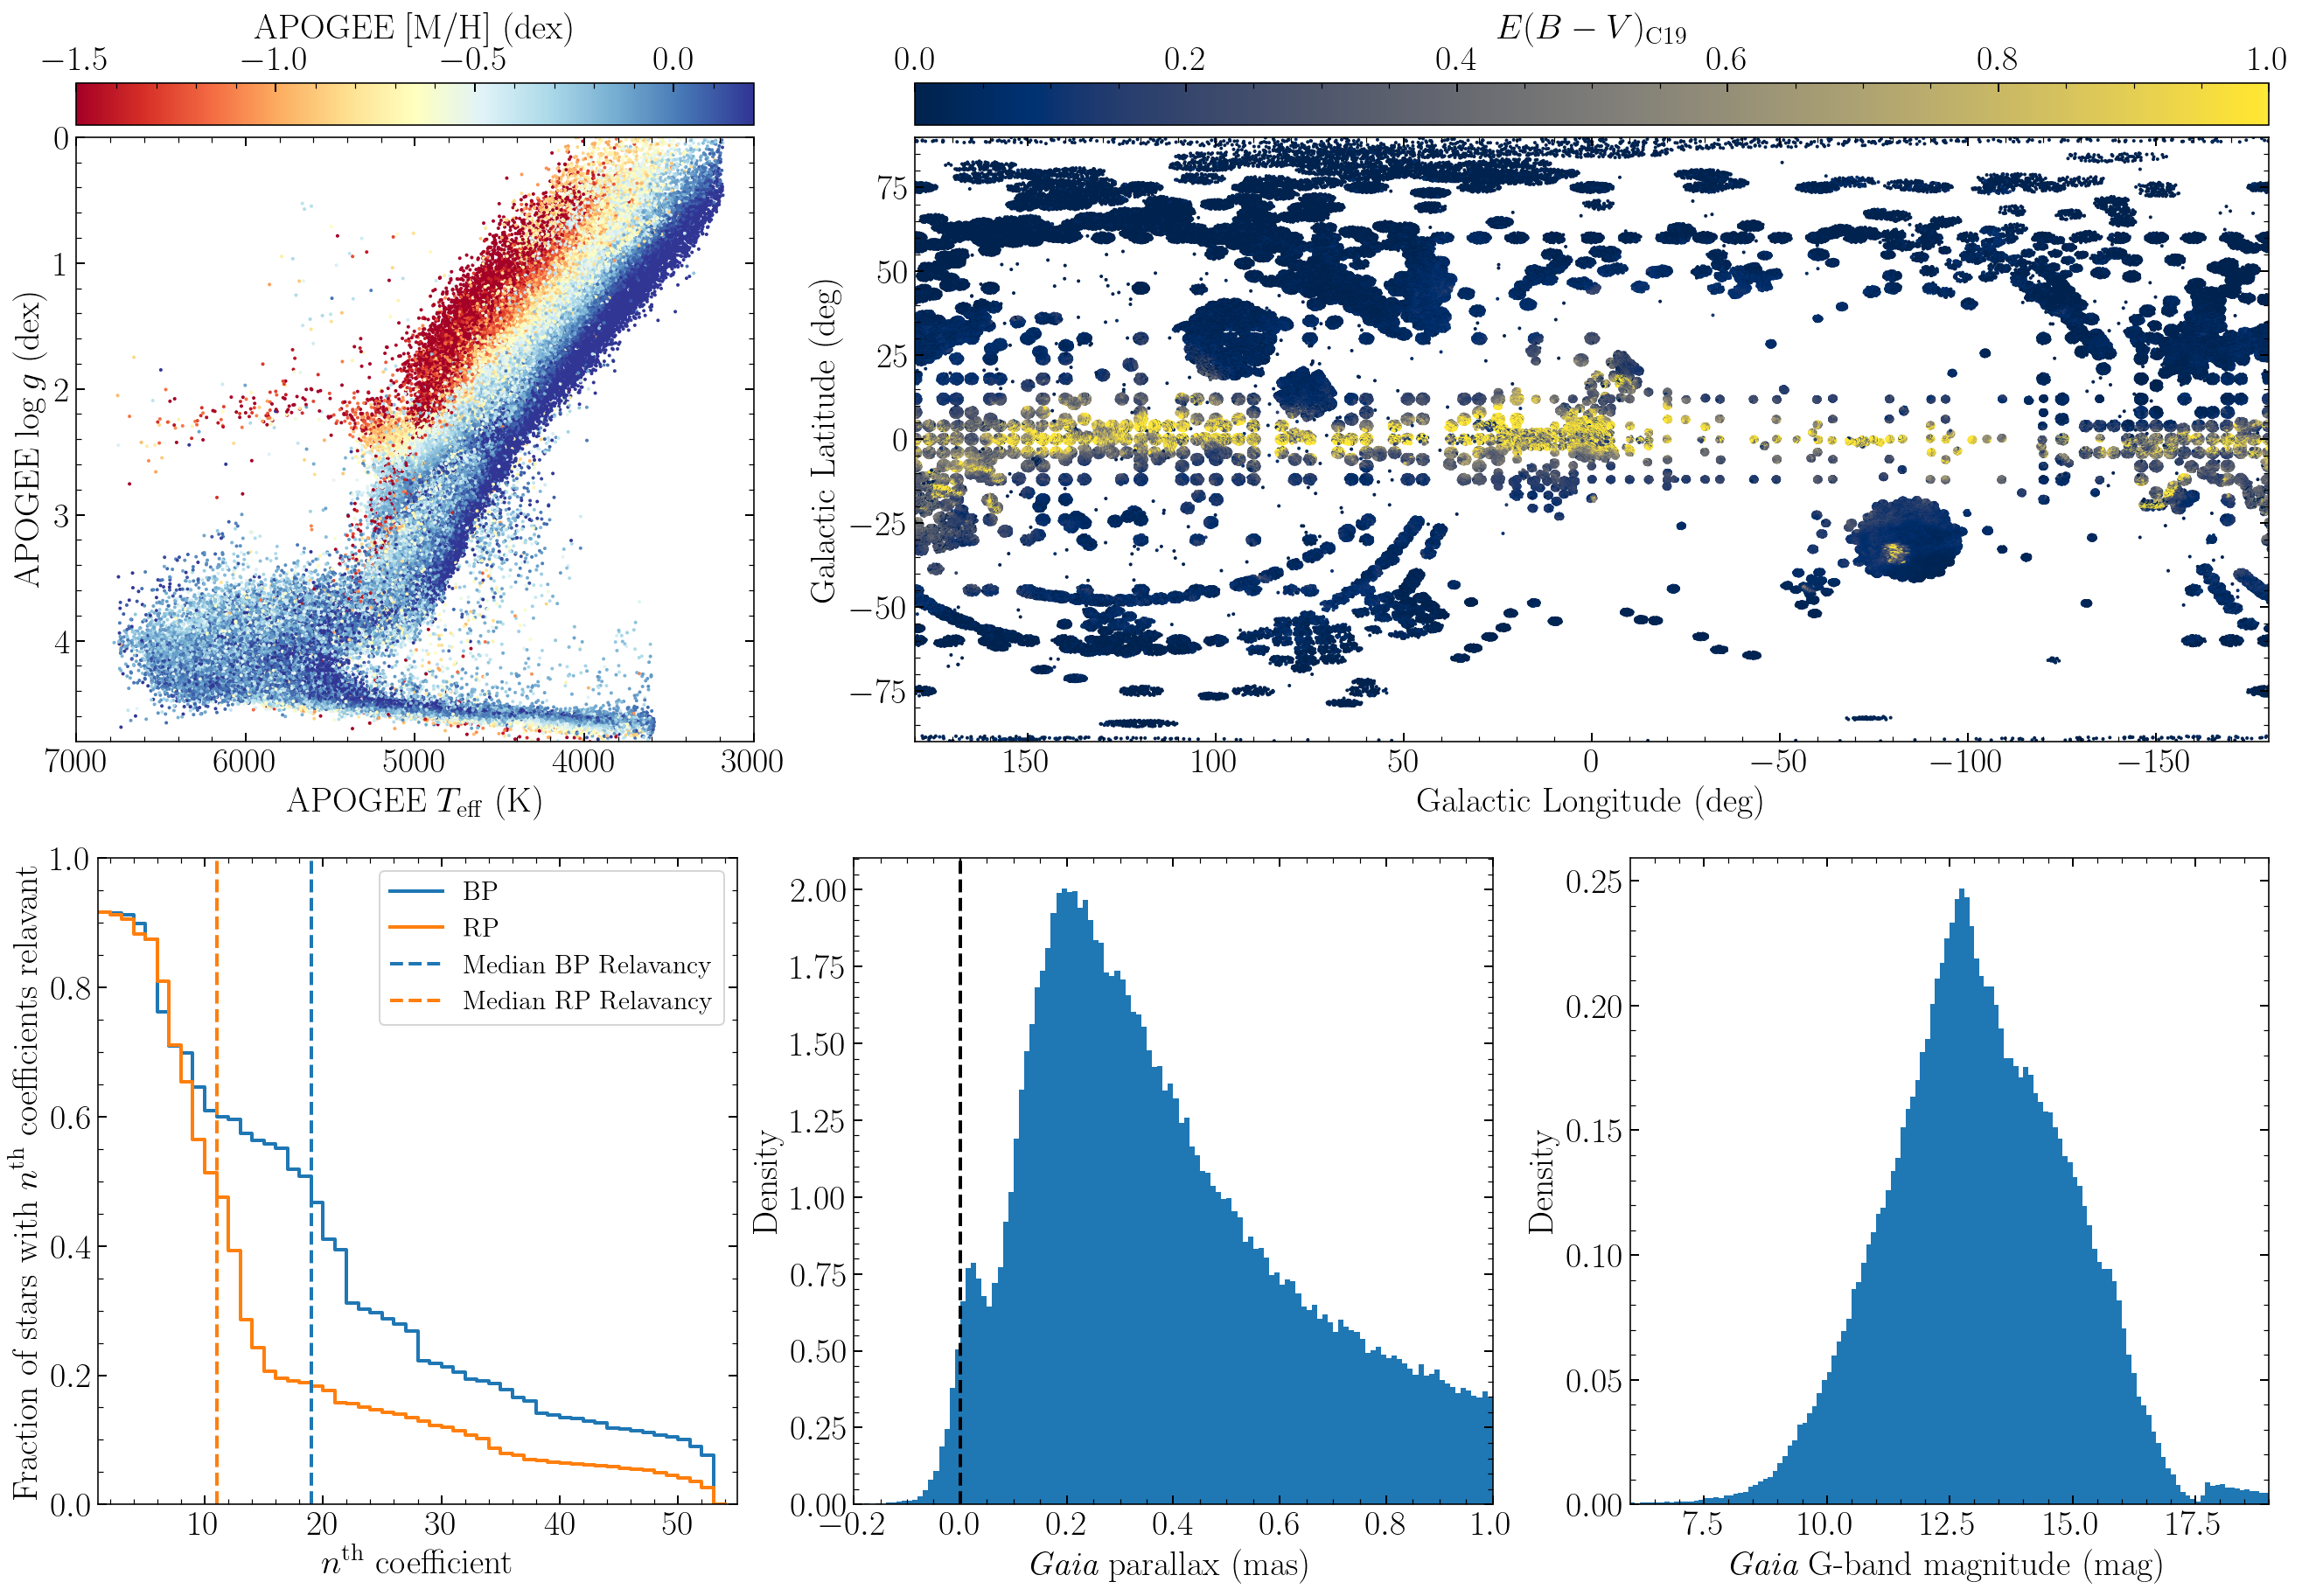

In [1]:
import h5py
import numpy as np
import pylab as plt
from astropy.io import fits
from astroNN.apogee import allstar
from astroNN.shared.matplotlib import pylab_style

from utils.plotting_utils import top_cbar

pylab_style(paper=True)

f_train = h5py.File("./data_files/training_set.h5", "r")
f_test = h5py.File("./data_files/testing_set.h5", "r")
allstar_f = fits.getdata(allstar(dr=17))
_, idx1, idx2 = np.intersect1d(
    ["2M" + i[0].decode() for i in f_train["2mass_designation"][()]],
    allstar_f["APOGEE_ID"],
    assume_unique=False,
    return_indices=True,
)

good_apogee_teffloggmh = np.sum(
    ~np.isnan(f_train["raw"]["teff"])
    & ~np.isnan(f_train["raw"]["logg"])
    & ~np.isnan(f_train["raw"]["m_h"])
)
print("Total number of training star: ", len(f_train["raw"]["teff"]))
print(
    "Number of training star with Teff, logg, [M/H]: ",
    np.sum(
        ~np.isnan(f_train["raw"]["teff"])
        & ~np.isnan(f_train["raw"]["logg"])
        & ~np.isnan(f_train["raw"]["m_h"])
    ),
)
print("Number of training star with Teff: ", np.sum(~np.isnan(f_train["raw"]["teff"])))
print(
    "Number of training star with XP: ",
    np.sum(~np.isnan(f_train["raw"]["xp_coeffs"][:, 0])),
)
print(
    "Number of training star with XP without any APOGEE: ",
    np.sum(
        ~np.isnan(f_train["raw"]["xp_coeffs"][:, 0]) & np.isnan(f_train["raw"]["teff"])
    ),
)
print(
    "Number of training star with APOGEE without XP: ",
    np.sum(
        np.isnan(f_train["raw"]["xp_coeffs"][:, 0]) & ~np.isnan(f_train["raw"]["teff"])
    ),
)
print(
    "Number of training star without good Gaia parallax: ",
    np.sum(np.isnan(f_train["raw"]["parallax"][()])),
)
print(
    "Number of training star without Combined19 reddening: ",
    np.sum(np.isnan(f_train["raw"]["logc19"][()])),
)
print(
    "Number of training star without 2MASS colors: ",
    np.sum(np.isnan(f_train["raw"]["jh"][()]))
    | np.sum(np.isnan(f_train["raw"]["jk"][()])),
)
# print("Total number of testing star: ", len(f_test["raw"]["teff"]))
# print("Number of testing star with Teff: ", np.sum(~np.isnan(f_test["raw"]["teff"])))
# print(
#     "Number of testing star with XP: ",
#     np.sum(~np.isnan(f_test["raw"]["xp_coeffs"][:, 0])),
# )
xp_relavancy = f_train["raw"]["xp_relevancy"][()]
bp_relavancy = np.sum(xp_relavancy[:, :55], axis=1)
rp_relavancy = np.sum(xp_relavancy[:, 55:], axis=1)
bp_values, bp_base = np.histogram(bp_relavancy, range=(0, 55), bins=55)
rp_values, rp_base = np.histogram(rp_relavancy, range=(0, 55), bins=55)
bp_cumulative = np.cumsum(bp_values)
rp_cumulative = np.cumsum(rp_values)

fig = plt.figure(constrained_layout=True, figsize=(18.0, 12.0))
subfigs = fig.subfigures(2, 1)
ax1, ax2 = subfigs[0].subplots(1, 2, gridspec_kw={"width_ratios": [1, 2]})
ax3, ax4, ax5 = subfigs[1].subplots(1, 3, gridspec_kw={"width_ratios": [1, 1, 1]})

mappable = ax1.scatter(
    f_train["raw"]["teff"],
    f_train["raw"]["logg"],
    c=f_train["raw"]["m_h"],
    s=1,
    vmin=-1.5,
    vmax=0.2,
    cmap="RdYlBu",
    rasterized=True,
)
ax1.set_xlim(7000, 3000)
ax1.set_ylim(4.8, 0.0)
ax1.set_xlabel("APOGEE $T_\mathrm{eff}$ (K)")
ax1.set_ylabel("APOGEE $\log{g}$ (dex)")
cbar = top_cbar(ax1, mappable, "APOGEE [M/H] (dex)")

mappable = ax2.scatter(
    (allstar_f["GLON"][idx2] + 180) % (2 * 180) - 180,
    allstar_f["GLAT"][idx2],
    c=np.exp(f_train["raw"]["logc19"][()][idx1]),
    s=1,
    vmin=0,
    vmax=1,
    cmap="cividis",
    rasterized=True,
)
ax2.set_xlim(180, -180)
ax2.set_ylim(-90, 90)
ax2.set_xlabel("Galactic Longitude (deg)")
ax2.set_ylabel("Galactic Latitude (deg)")
cbar = top_cbar(ax2, mappable, "$E(B-V)_\mathrm{C19}$")

ax3.plot(
    bp_base[:-1],
    1 - bp_cumulative / len(bp_relavancy),
    drawstyle="steps-post",
    c="C0",
    lw=2,
    label="BP",
)
ax3.plot(
    rp_base[:-1],
    1 - rp_cumulative / len(rp_relavancy),
    drawstyle="steps-post",
    c="C1",
    lw=2,
    label="RP",
)
ax3.axvline(np.median(bp_relavancy), ls="--", lw=2, c="C0", label="Median BP Relavancy")
ax3.axvline(np.median(rp_relavancy), ls="--", lw=2, c="C1", label="Median RP Relavancy")
ax3.set_xlim(1, 55)
ax3.set_ylim(0, 1)
ax3.set_xlabel("$n^\mathrm{th}$ coefficient")
ax3.set_ylabel("Fraction of stars with $n^\mathrm{th}$ coefficients relavant")
ax3.legend(loc="upper right")

ax4.hist(
    f_train["raw"]["parallax"][()],
    range=(-0.2, 1),
    bins=120,
    density=True,
    rasterized=True,
)
ax4.axvline(0.0, ls="--", lw=2, c="k")
ax4.set_xlim(-0.2, 1.0)
ax4.set_xlabel("$\\textit{Gaia}$ parallax (mas)")
ax4.set_ylabel("Density")

ax5.hist(
    f_train["raw"]["phot_g_mean_mag"][()],
    range=(6, 19),
    bins=130,
    density=True,
    rasterized=True,
)
ax5.axvline(0.0, ls="--", lw=2, c="k")
ax5.set_xlim(6, 19)
ax5.set_xlabel("$\\textit{Gaia}$ G-band magnitude (mag)")
ax5.set_ylabel("Density")

fig.savefig("./figs/training_set.pdf", dpi=100, bbox_inches="tight")
